In [2]:
#!pip install sklearn-pandas

import sqlite3
import pandas as pd
import sklearn
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
import re
import glob
import sys
import os
import re
import csv
import math
from datetime import datetime

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.svm import LinearSVR
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score



C:\Users\zshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\zshi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# NOT IN USE

# # set up sqlite database
# conn = sqlite3.connect('C:\\Users\\zshi\\Downloads\\lending-club-loan-data\\database.sqlite')
# c = conn.cursor()
# cursor = c.execute('select * from loan')

# # read data from the sqlite database
# names = list(map(lambda x: x[0], cursor.description))
# c.execute("SELECT * FROM loan;")
# available_table=(c.fetchall())
# lc = pd.DataFrame(available_table)
# lc.columns = names

# Loading data

In [ ]:
# read data between 2007-2018

path =r'H:\\lending-club-loan-data\\raw data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [ ]:
# examine data type
print(lc_all.info())

In [ ]:
# restrict to loans with final status
lc_all = lc_all.loc[(lc_all['loan_status'] != 'Current') & (lc_all['loan_status'] != 'Issued')]
lc_all.loan_status.value_counts()

In [ ]:
# export combined new data

lc_all.to_csv('H:\\lending-club-loan-data\\lc_all.gz', compression='gzip')

In [ ]:
# load newer data from combined csv file

lc_all = pd.read_csv('H:\\lending-club-loan-data\\lc_all.gz', compression='gzip',low_memory=False)

# Data cleaning

In [ ]:
# check distribution of loan status
lc_all['loan_status'].value_counts()

In [ ]:
# recode loan status as binary
def bin_loan (x):
   if (x == 'Fully Paid') | (x == 'Does not meet the credit policy. Status:Fully Paid'):
      return 0
   return 1

lc_all['loan_status_bin'] = lc_all['loan_status'].apply(bin_loan)

# check recoded frequency
pd.crosstab( lc_all['loan_status'], lc_all['loan_status_bin'],
            rownames=['Original status'], colnames=['Binary status'])

In [ ]:
# plot correlation matrix
plt.figure(figsize=(11,11))
plt.matshow(lc_all.corr(), fignum=1)

In [ ]:
# cleaning & creating variables


# convert interest rate to numeric
lc_all['int_rate_n'] = lc_all['int_rate'] = lc_all['int_rate'].str.replace("%", "").str.replace(" ", "")
lc_all['int_rate_n'] = pd.to_numeric(lc_all['int_rate_n'])


# recode employ years
def recode_empyear (x):
    if x=='10+ years':
        return '10+ years'
    elif (x=='< 1 year')|(x=='1 year')|(x=='2 years')|(x=='3 years')|(x=='4 years')|(x=='5 years'):
        return '1-5 years'
    else:
        return '5-10 years'

lc_all['emp_length_n'] = lc_all['emp_length'].apply(recode_empyear)


# recode home ownership
def recode_home (x):
    if (x=='NONE')|(x=='ANY')|(x=='OTHER'):
        return 'OTHER'
    else:
        return x

lc_all['home_ownership_n'] = lc_all['home_ownership'].apply(recode_home)
lc_all['home_ownership_n'].value_counts()


# convert revol_util to numeric
lc_all['revol_util_n'] = lc_all['revol_util'].str.replace("%", "")
lc_all['revol_util_n'] = pd.to_numeric(lc_all['revol_util_n'])


# calcualte mean fico score
lc_all['fico_avg'] = (lc_all['fico_range_high'] + lc_all['fico_range_low'])/2


# get length of loan description
def desc_len (x):
    if x=='nan':
        return ''
    else:
        return re.sub(".*> |<br>|<br/>", "", x)
    
lc_all['desc1'] = lc_all['desc'].astype(str)
lc_all['desc1'] = lc_all['desc1'].apply(desc_len)
lc_all['desc1'] = lc_all['desc1'].str.len()


# calculate time since first credit line
now = datetime.now()
def credit_age (x):
    if x != 'nan':
        c1 = datetime.strptime(x, '%b-%Y')
        return (now-c1).days/365.25
        #return c1
    else:
        return None

lc_all['earliest_cr_line_n'] = lc_all['earliest_cr_line'].astype(str)
lc_all['earliest_cr_line_n'] = lc_all['earliest_cr_line_n'].apply(credit_age)


# create region of residence based on state
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
lc_all['region'] = lc_all['addr_state'].apply(finding_regions)

# drop rows without region value
lc_all.dropna(subset=['region'],inplace=True)


# create year when loan issued
dt_series = pd.to_datetime(lc_all['issue_d'])
lc_all['year'] = dt_series.dt.year

# recode loan purpose 
lc_all['purpose_g'] = np.nan

lc_all.loc[(lc_all['purpose'] == 'debt_consolidation')|(lc_all['purpose'] =="credit_card"), 'purpose_g'] = 'debt' 
lc_all.loc[(lc_all['purpose'] == 'home_improvement')|(lc_all['purpose'] =="major_purchase")|
                 (lc_all['purpose'] == 'car')|(lc_all['purpose'] =="house")|
                 (lc_all['purpose'] == 'vacation')|(lc_all['purpose'] =="renewable_energy"),
                 'purpose_g'] = 'major_purchase' 
lc_all.loc[(lc_all['purpose'] == 'small_business')|(lc_all['purpose'] =="medical")|
                 (lc_all['purpose'] == 'moving')|(lc_all['purpose'] =="wedding")|
                 (lc_all['purpose'] == 'educational'),
                 'purpose_g'] = 'life_event'
lc_all.loc[(lc_all['purpose'] == 'other'), 'purpose_g'] = 'other'

In [ ]:
# Handling Missing Numeric Values

# Copy Dataframe
complete_lc_all = lc_all.copy()

# fill zero for the numeric dataframe
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util_n', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    complete_lc_all[col] = complete_lc_all[col].fillna(0)
    
# fill mode for when the last credit was pulled
#complete_lc_all["last_credit_pull_d"] = complete_lc_all.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))

# fill median for fico score
complete_lc_all["fico_avg"] = complete_lc_all.groupby("region")["fico_avg"].transform(lambda x: x.fillna(x.median()))

# fill median for interest rate
complete_lc_all["int_rate_n"] = complete_lc_all.groupby("region")["int_rate_n"].transform(lambda x: x.fillna(x.median()))

# fill median for credit age
complete_lc_all["earliest_cr_line_n"] = complete_lc_all.groupby("region")["earliest_cr_line_n"].transform(lambda x: x.fillna(x.median()))

# fill median for public records
complete_lc_all["pub_rec"] = complete_lc_all.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# fill median for annual income depending in the region the client is located.
complete_lc_all["annual_inc"] = complete_lc_all.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.median()))

# fill mode for home ownership
complete_lc_all["home_ownership_n"] = complete_lc_all.groupby("region")["home_ownership_n"].transform(lambda x: x.fillna(x.mode()))

# fill median for credit lines the borrower has 
complete_lc_all["total_acc"] = complete_lc_all.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# fill median for number of delinquencies in the past two years.
complete_lc_all["delinq_2yrs"] = complete_lc_all.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.median()))


In [ ]:
# get non-none values for each col
var_n = pd.DataFrame(complete_lc_all.count()).reset_index()
var_n.columns=['index', 'n']

# get correlation with binary outcome
var_cor = pd.DataFrame((complete_lc_all.corr()['loan_status_bin'])).reset_index()
var_cor.columns=['index', 'correlation']

# get data type
var_type = pd.DataFrame(complete_lc_all.dtypes).reset_index()
var_type.columns=['index', 'type']
var_type

# load data dictionary
var_dict = pd.read_csv('H:\\lending-club-loan-data\\dictionary.csv', encoding = "ISO-8859-1")
var_dict.columns = ['index','Description']

In [ ]:
# function to compare test correlation between each var vs. loan status

def do_test(x):
    # do t test for continuous var
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        group1, group2 = [g[1] for g in x.groupby(complete_lc_all['loan_status_bin'])]
        t, p = scipy.stats.ttest_ind(group1, group2,nan_policy='omit')
        if np.isnan(np.ma.getdata(t)):
            p=1
        return p
    
    # do chi squared test for categorical var
    if x.dtypes == 'object':
        observed = pd.crosstab(x, complete_lc_all['loan_status_bin'])
        chi, p = scipy.stats.chi2_contingency(observed, correction=False)[0:2]
        return p

In [ ]:
# calculate p values for all variables
pval = pd.DataFrame(complete_lc_all.apply(do_test)).reset_index()
pval.columns=['index', 'p']

In [ ]:
# merger p value and variable info together and sort
var_info = pd.merge(var_n, pval, how='left', on=['index'])
var_info = pd.merge(var_info, var_type, how='left', on=['index'])
var_info = pd.merge(var_info, var_dict, how='left', on=['index'])
var_select = var_info.loc[((var_info['n']/len(lc_all)>.95)) & (var_info['p'] < 0.05/len(var_info))]
var_select.to_csv('H:\\lending-club-loan-data\\selected vars.csv')

print('Total number of variables selected =',len(var_select))
print('Type of variables:')
print(var_select['type'].value_counts())

plt.plot(var_select['p'],'ro')
var_select.sort_values(by=['index'])


In [ ]:
# check weired income data

lc_all.annual_inc.hist()

In [ ]:
# save the cleaned data

complete_lc_all.to_csv('H:\\lending-club-loan-data\\complete_lc_all.gz', compression='gzip')

# Read cleaned final data here:

In [ ]:
# load cleaned data csv file, change to the correct path

complete_lc_all = pd.read_csv('H:\\lending-club-loan-data\\complete_lc_all.gz', compression='gzip',low_memory=False)

# Under-resampling to reduce imbalance

In [4]:
# Class count
count_class_0, count_class_1 = complete_lc_all.loan_status_bin.value_counts()

# Divide by class
df_class_0 = complete_lc_all[complete_lc_all['loan_status_bin'] == 0]
df_class_1 = complete_lc_all[complete_lc_all['loan_status_bin'] == 1]

Random under-sampling:
1    247213
0    247213
Name: loan_status_bin, dtype: int64


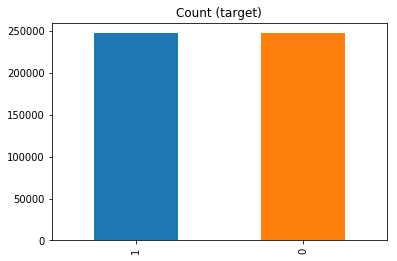

In [5]:
# random sampling
df_class_0_under = df_class_0.sample(count_class_1)
lc_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(lc_under.loan_status_bin.value_counts())

lc_under.loan_status_bin.value_counts().plot(kind='bar', title='Count (target)');

# Data preparation for modeling

In [6]:
# create dataframes 
y, X = dmatrices('loan_status_bin ~ annual_inc+ chargeoff_within_12_mths+ delinq_2yrs+ dti+ \
                    inq_last_6mths+loan_amnt+open_acc+pub_rec+pub_rec_bankruptcies+revol_util_n+revol_bal+total_acc+\
                    emp_length_n+home_ownership_n+purpose_g+term+verification_status+earliest_cr_line_n+\
                    fico_avg+desc1+int_rate_n+application_type+grade+region+year+installment',
                  lc_under, return_type="dataframe")
print(X.columns)

y = np.ravel(y)
X.info()

Index(['Intercept', 'emp_length_n[T.10+ years]', 'emp_length_n[T.5-10 years]',
       'home_ownership_n[T.OTHER]', 'home_ownership_n[T.OWN]',
       'home_ownership_n[T.RENT]', 'purpose_g[T.life_event]',
       'purpose_g[T.major_purchase]', 'purpose_g[T.other]',
       'term[T. 60 months]', 'verification_status[T.Source Verified]',
       'verification_status[T.Verified]', 'application_type[T.Joint App]',
       'grade[T.B]', 'grade[T.C]', 'grade[T.D]', 'grade[T.E]', 'grade[T.F]',
       'grade[T.G]', 'region[T.NorthEast]', 'region[T.SouthEast]',
       'region[T.SouthWest]', 'region[T.West]', 'annual_inc',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'inq_last_6mths',
       'loan_amnt', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',
       'revol_util_n', 'revol_bal', 'total_acc', 'earliest_cr_line_n',
       'fico_avg', 'desc1', 'int_rate_n', 'year', 'installment'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 493697 entries, 398066 to 1061093

In [7]:
# Splitting into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [8]:
# standardize numeric value

mapper = DataFrameMapper([
        (['loan_amnt'], [Imputer(), StandardScaler()]),
        (['int_rate_n'], [Imputer(), StandardScaler()]),
        (['annual_inc'], [Imputer(), StandardScaler()]),
        (['dti'], [Imputer(), StandardScaler()]),
        (['delinq_2yrs'], [StandardScaler()]),
        (['inq_last_6mths'], [Imputer(), StandardScaler()]),
        (['chargeoff_within_12_mths'], [Imputer(), StandardScaler()]),
        (['open_acc'], [Imputer(), StandardScaler()]),
        (['pub_rec'], [Imputer(), StandardScaler()]),
        (['pub_rec_bankruptcies'], [Imputer(), StandardScaler()]),
        (['revol_bal'], [Imputer(), StandardScaler()]),
        (['revol_util_n'], [Imputer(), StandardScaler()]),
        (['total_acc'], [Imputer(), StandardScaler()]),
        (['year'], [Imputer(), StandardScaler()]),
        (['earliest_cr_line_n'], [Imputer(), StandardScaler()]),
        (['fico_avg'], [Imputer(), StandardScaler()]),
        (['desc1'], [StandardScaler()]),
        (['installment'], [Imputer(), StandardScaler()]),
    ])

X_train = mapper.fit_transform(X_train)
X_test = mapper.transform(X_test)

# Logistic regression


In [19]:
# logisti model in statsmodels

model=sm.Logit(y,X)
result=model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.615783
         Iterations 7
                                       Results: Logit
Model:                       Logit                     No. Iterations:            7.0000     
Dependent Variable:          y                         Pseudo R-squared:          0.112      
Date:                        2018-08-01 14:11          AIC:                       608102.9031
No. Observations:            493697                    BIC:                       608558.3999
Df Model:                    40                        Log-Likelihood:            -3.0401e+05
Df Residuals:                493656                    LL-Null:                   -3.4220e+05
Converged:                   1.0000                    Scale:                     1.0000     
---------------------------------------------------------------------------------------------
                                         Coef.   Std.Err.    z     P>|z|    [0.025    0.975]

In [ ]:
# # logistic regression model in scikit learn
# model = LogisticRegression()
# model = model.fit(X, y)

# # check the accuracy 
# model.score(X, y)

In [ ]:
# # evaluate the model using 10-fold cross-validation
# scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
# print(scores)
# print(scores.mean())


In [20]:
# Logistic regression
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# generate evaluation metrics

probs = model2.predict_proba(X_test)
predicted = model2.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.713
Mean accuracy score: 0.657
[[81472 42121]
 [42556 80700]]
             precision    recall  f1-score   support

        0.0       0.66      0.66      0.66    123593
        1.0       0.66      0.65      0.66    123256

avg / total       0.66      0.66      0.66    246849



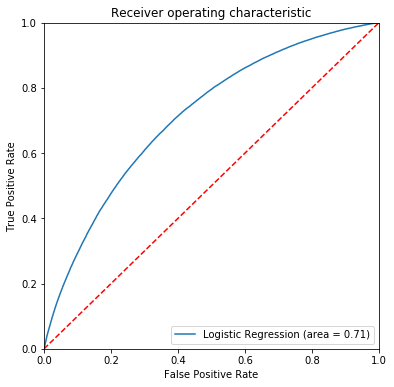

In [22]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3, max_features='log2', oob_score=True,  random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [24]:
# generate evaluation metrics

probs = rf.predict_proba(X_test)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

print(f'AUC estimate: {auc:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.701
Out-of-bag score estimate: 0.644
Mean accuracy score: 0.646
[[75446 48147]
 [39224 84032]]
             precision    recall  f1-score   support

        0.0       0.66      0.61      0.63    123593
        1.0       0.64      0.68      0.66    123256

avg / total       0.65      0.65      0.65    246849



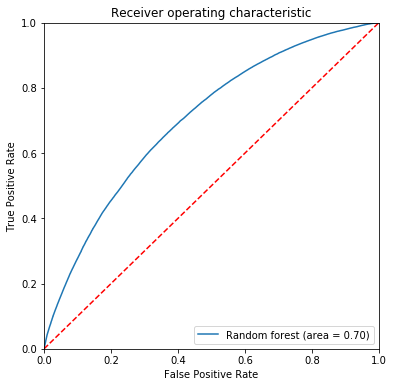

In [25]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Random forest (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RandomForest_ROC')
plt.show()

# Decision tree

In [26]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
probs = clf.predict_proba(X_test)
predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.571
Out-of-bag score estimate: 0.644
Mean accuracy score: 0.571
[[70593 53000]
 [52912 70344]]
             precision    recall  f1-score   support

        0.0       0.57      0.57      0.57    123593
        1.0       0.57      0.57      0.57    123256

avg / total       0.57      0.57      0.57    246849



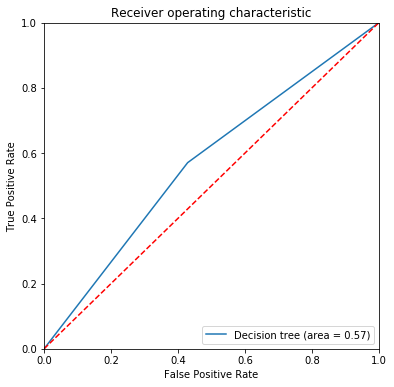

In [28]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()

# Neural network

In [29]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [30]:
probs = nn.predict_proba(X_test)
predicted = nn.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.699
Mean accuracy score: 0.649
[[82576 41017]
 [45736 77520]]
             precision    recall  f1-score   support

        0.0       0.64      0.67      0.66    123593
        1.0       0.65      0.63      0.64    123256

avg / total       0.65      0.65      0.65    246849



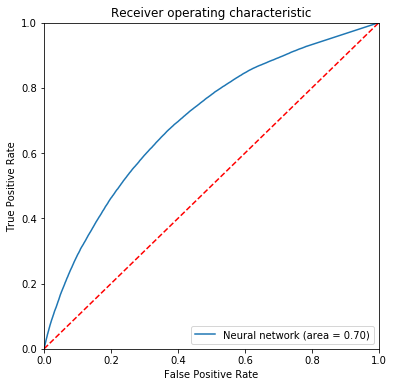

In [31]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, nn.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Neural network (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NeuralNetwork_ROC')
plt.show()

# Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [33]:
probs = gnb.predict_proba(X_test)
predicted = gnb.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.672
Mean accuracy score: 0.617
[[56303 67290]
 [27144 96112]]
             precision    recall  f1-score   support

        0.0       0.67      0.46      0.54    123593
        1.0       0.59      0.78      0.67    123256

avg / total       0.63      0.62      0.61    246849



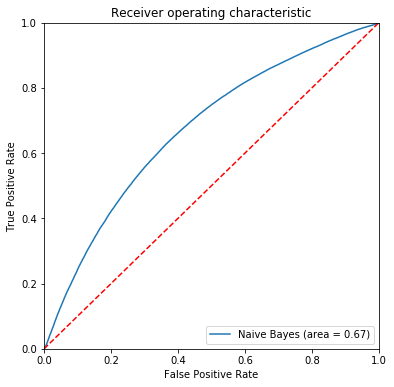

In [34]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NaiveBayes_ROC')
plt.show()

# Linear discriminant analysis

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [36]:
probs = lda.predict_proba(X_test)
predicted = lda.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.712
Mean accuracy score: 0.656
[[81836 41757]
 [43099 80157]]
             precision    recall  f1-score   support

        0.0       0.66      0.66      0.66    123593
        1.0       0.66      0.65      0.65    123256

avg / total       0.66      0.66      0.66    246849



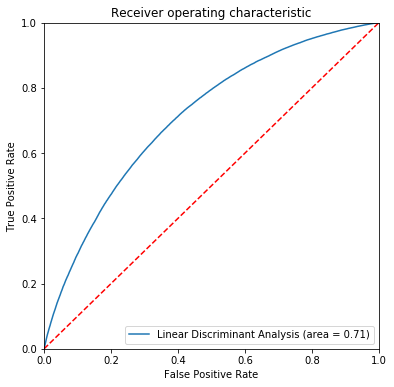

In [37]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, lda.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Linear Discriminant Analysis (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LDA_ROC')
plt.show()

# Gradient boosting - WINNER!

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(n_estimators=200,max_depth=3)
gradboost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [17]:
probs = gradboost.predict_proba(X_test)
predicted = gradboost.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

AUC estimate: 0.726
Mean accuracy score: 0.665
[[79294 44299]
 [38278 84978]]
             precision    recall  f1-score   support

        0.0       0.67      0.64      0.66    123593
        1.0       0.66      0.69      0.67    123256

avg / total       0.67      0.67      0.67    246849



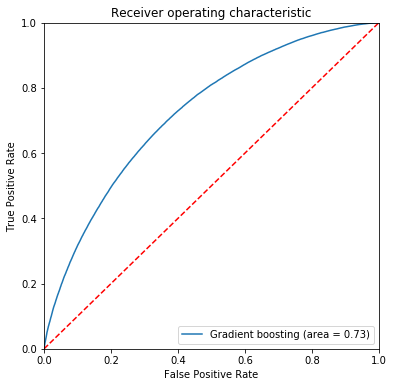

In [18]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, gradboost.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Gradient boosting (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GradientBoost_ROC')
plt.show()

# KNN - super slow, do not run on laptop

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

In [ ]:
probs = neigh.predict_proba(X_test)
predicted = neigh.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

In [ ]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

# Support vector machine - super slow, do not run on laptop

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1E10)
svm.fit(X, y)

In [ ]:
probs = svm.predict_proba(X_test)
predicted = svm.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))